In [4]:
import datetime

from Decoder import *
from Finger import *
from LanguageModel import *
from TouchModel import *
from Keyboard import *
from metrics import *
from read_corpus import *
from visualiser import *
from Eye import *
import random
from Executor2 import *
from SpatialMemory import *

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import sympy as sp
from scipy.stats import entropy

import json


In [5]:
def decayfunc(x, a, b, c):
    return a * np.exp(-b * x) + c

def powerfunc(x, a, b):
    return a*(x**b)

def logistic_function (x, K, k, x0):
        #P(t) = K / (1 + e^(-k(t-t0)))
        #P(t) is performance at time t
        #K is the upper limit (maximum performance)
        #r is the learning rate
        #t0 is the midpoint time (inflection point)
        return K / (1 + math.e**(-k * (x - x0)))

In [6]:
# 8 participants, each participant types 8*12 phrases = 96

f=open('virtual_participants/popts_all.json')
participants = list(json.load(f).keys())
nparticipants = 5
participants = random.sample(participants, k=nparticipants)
#participants = sorted(list(json.load(f).keys()))[0:1]
layout = [2,1]

print (len(participants), participants)

trials = 10
sessions = 50
session_limit=20 #minutes

5 ['109', '120', '115', '127', '106']


In [14]:
def runexp(keyboard, participants):
    corpus = read_soukoreff('phrase_sets/mackenzie_and_soukoreff/mackenzie.txt')
    
    
    final_wpms = []
    final_wpm_sds = []
    final_kspcs = []
    final_blocks = []
    for p in participants:
        #select a phrase and remove it from corpus
        phraseidx = random.choice(range(0, len(corpus)))
        phrase = corpus.pop(phraseidx)
    
        #load participant
        eye = Eye()
        myfinger=Finger('virtual_participants/popts_all.json', p)
        mykeyboard = Keyboard('keyboards/'+keyboard+'.xml', 'languagemodel.json', 'touchmodel.json', [1400,1000],[0,0], usedecoder=False)
        sm = SpatialMemory(mykeyboard,region_columns=layout[0],region_rows=layout[1], learningRate=0.002, adjustment='dynamic')
        executor = Executor2(myfinger, eye, mykeyboard, sm, expert_factor=0.1)
        executor.memoryUpdateMethod = "logistic"
       
        print (p)
        
        all_wpms=[]
        all_wpms_sds=[]
        all_kspcs=[]
        all_blocks=[]
        for session in range(sessions):
            session_wpms=[]
            session_kspcs=[]
    
            timepassed = 0
            nblocks=0
            while timepassed<=session_limit:
                #create a new block of phrases
                phrases = random.sample(corpus, trials)
                for i in range(len(phrases)):
                    #type each phrase
                    #reset state
                    mykeyboard.outputbuffer=[]
                    mykeyboard.current_word=[]
                    mykeyboard.taps=[]
                    eye.position = [mykeyboard.xdim/2, mykeyboard.ydim/2]
                    executor.eye_positions=[]
                    taps = executor.typeSentenceWithCorrection2(phrases[i], speed=1, noticeprob=1, slides='on', completions=False)
                    session_wpms.append(taps['wpm'])
                    session_kspcs.append(taps['kspc'])
                    timepassed+=taps['time'] #minutes
                    timepassed+=5/60 #add 5 seconds between phrases
                    #print (session, nblocks, i, taps['wpm'], timepassed)
                nblocks+=1
                
                #print ("=====")
                #print (session, nblocks, taps['wpm'], timepassed)
                #print ("=====")
                    
            #phrases = random.sample(corpus, trials) #80 phrases per session
            #for i in range(len(phrases)):
            #    #reset state
            #    mykeyboard.outputbuffer=[]
            #    mykeyboard.current_word=[]
            #    mykeyboard.taps=[]
            #    eye.position = [mykeyboard.xdim/2, mykeyboard.ydim/2]
            #    executor.eye_positions=[]
            #    taps = executor.typeSentenceWithCorrection2(phrases[i], speed=1, noticeprob=1, slides='on', completions=False)
            #    wpms.append(taps['wpm'])
            #    kspcs.append(taps['kspc'])
            
            #print(p, session, nblocks, np.mean(session_wpms), np.mean(session_kspcs), sep='\t')
            all_wpms.append(np.mean(session_wpms))
            all_kspcs.append(np.mean(session_kspcs))
            all_wpms_sds.append(np.std(session_wpms))
            all_blocks.append(nblocks)
        
        final_wpms.append(all_wpms)
        final_wpm_sds.append(all_wpms_sds)
        final_kspcs.append(all_kspcs)
        final_blocks.append(all_blocks)

        print(p, np.mean(final_wpms), np.std(final_wpms), sep='\t')

    #run stats

    means = []
    for i in range(sessions):
        mean = []
        for p in range(len(participants)):
            mean.append(final_wpms[p][i])
        means.append(np.mean(mean))
    
    sdmeans = []
    for i in range(sessions):
        sdmean = []
        for p in range(len(participants)):
            sdmean.append(final_wpms[p][i])
        sdmeans.append(np.std(sdmean))

    blocks = []
    for i in range(sessions):
        b = []
        for p in range(len(participants)):
            b.append(final_blocks[p][i])
        blocks.append(np.mean(b))

    cis = []
    for i in range(sessions):
        sd = []
        for p in range(len(participants)):
            sd.append(final_wpms[p][i])
        cis.append(1.96*np.std(sd)/np.sqrt(len(participants)))

    delta_wpm = (means[19] - means[0])/means[0]
    print(round(delta_wpm,4)*100)
    print(means[0], sdmeans[0])
    print(means[19], sdmeans[19])
    print(means[len(means)-1], sdmeans[len(sdmeans)-1])
    
    return means, sdmeans, cis

def plotdata(means, sdmeans, cis):
    #plot

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    axes=[axes]
    
    #print actual session stats
    axes[0].scatter(range(len(means)), means, marker='.', alpha=0.5)
    #axes[1].plot(range(len(all_kspcs)), all_kspcs)
    axes[0].fill_between(
        range(len(means)), 
        [x - y for x, y in zip(means, cis)],
        [x + y for x, y in zip(means, cis)], 
        color='b', alpha=.15)
    
    
    #fit the function to first 20 sessions
    popt, pcov = curve_fit(powerfunc, range(1,21), means[0:20], maxfev=1000)
    y_pred = powerfunc(range(1,len(means)+1), *popt)
    r2=round(r2_score(means[0:20], y_pred[0:20]),3)
    print(r2)
    popt=np.append(popt,r2)
    r2=round(r2_score(means, y_pred),3)
    print(r2)
    popt=np.append(popt,r2)
    print(popt)
    label="$f(x)=%5.3fx^{%5.3f}, R^2=%5.3f, (%5.3f)$" %tuple(popt)
    axes[0].plot(range(1,len(means)+1), y_pred, label=label)
    
    #label=str(layout[0])+'x'+str(layout[1])+ ', $R^2$='+str(r2), #' - fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt), 
    
    
    #def logistic_function (x, K, k, x0):
    p0=(35,0.2,0)
    popt, pcov = curve_fit(logistic_function, range(1,21), means[0:20], maxfev=1000, p0=p0)
    y_pred = logistic_function(range(1,len(means)+1), *popt)
    r2=round(r2_score(means[0:20], y_pred[0:20]),3)
    print(r2)
    popt=np.append(popt,r2)
    r2=round(r2_score(means, y_pred),3)
    print(r2)
    popt=np.append(popt,r2)
    print(popt)
    if (popt[2]<0):
        sym="+"
    else:
        sym="-"
    popt[2]=abs(popt[2])
    label=("$f(x)=%5.3f/(1+e^{-%5.3f(x"+sym+"%5.3f)}), R^2=%5.3f, (%5.3f)$") %tuple(popt)
    axes[0].plot(range(1,len(means)+1), y_pred, label=label)
    
    #axes[0].plot(range(1,len(means)+1), y_pred,label="$f(x)=K/(1+e^{-k(x-x_0)}), R^2="+str(round(r2,3))+"$")
    
    #mackenzie's function
    #popt=np.array([17.24,0.3219])
    popt=np.array([27.597,0.1237])
    y_pred=powerfunc(range(1,len(means)+1),*popt)
    r2=round(r2_score(means[0:20], y_pred[0:20]),3)
    print(r2)
    popt=np.append(popt,r2)
    r2=round(r2_score(means, y_pred),3)
    print(r2)
    popt=np.append(popt,r2)
    print(popt)
    label="$f(x)=%5.3fx^{%5.3f}, R^2=%5.3f, (%5.3f)$" %tuple(popt)
    axes[0].plot(range(1,len(means)+1), y_pred, label=label)
    
    axes[0].legend()
    axes[0].set_ylim(0,65)
    axes[0].set_xlim(1,len(means)+1)
    axes[0].set_xlabel('Session')
    axes[0].set_ylabel('WPM')
    axes[0].vlines(x = 20,
                      ymin=0,
                      ymax=65,
                      color = 'black', linestyle='dashed', alpha=0.8)
    plt.show()

In [8]:
m,s,c=runexp('qwerty', participants)

Reconstructed object
109
109	28.16446422802648	2.483673496283332
Reconstructed object
120
120	23.21193879830945	5.3539759020548745
Reconstructed object
115
115	23.23748651943636	4.514799180130714
Reconstructed object
127
127	23.524381298269354	4.100449477887692
Reconstructed object
106
106	23.513667698382072	3.7821419934085267


In [10]:
delta_wpm = (m[19] - m[0])/m[0]
print(round(delta_wpm,4)*100)
print(m[0], s[0])
print(m[19], s[19])
print(m[len(m)-1], s[len(s)-1])

64.98
14.799084634654946 1.5862281516680985
24.415332620802012 3.478718821930846
24.411102826086353 3.479598794151291


0.945
-0.597
[15.88721607  0.15433643  0.945      -0.597     ]
0.991
0.98
[24.17816903  0.32411391 -0.54630681  0.991       0.98      ]
-26.449
-68.85
[ 27.597    0.1237 -26.449  -68.85  ]


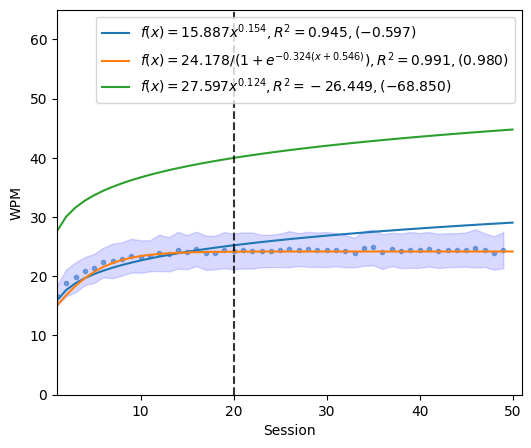

In [9]:
plotdata(m,s,c)

In [12]:
m1,s1,c1=runexp('opti', participants)

Reconstructed object
109
109	33.535900654274	2.118824032537667
Reconstructed object
120
120	27.60108970480419	6.175031499832351
Reconstructed object
115
115	27.550475709615604	5.130481636864555
Reconstructed object
127
127	27.595226125422233	4.531832864796351
Reconstructed object
106
106	27.79080824662144	4.147545059011641
32.06
20.69343011507168 2.1922022278568254
27.327990674928806 3.7649571426962556
28.62543090292568 3.821003693110724


In [15]:
delta_wpm = (m1[19] - m1[0])/m1[0]
print(round(delta_wpm,4)*100)
print(m1[0], s1[0])
print(m1[19], s1[19])
print(m1[len(m1)-1], s1[len(s1)-1])

37.09
20.69343011507168 2.1922022278568254
28.368584453821956 3.8216605511827892
28.62543090292568 3.821003693110724


0.94
-0.278
[21.38993746  0.10270067  0.94       -0.278     ]
0.993
0.973
[28.27207521  0.31417747 -2.18126892  0.993       0.973     ]
-18.169
-57.19
[ 27.597    0.1237 -18.169  -57.19  ]


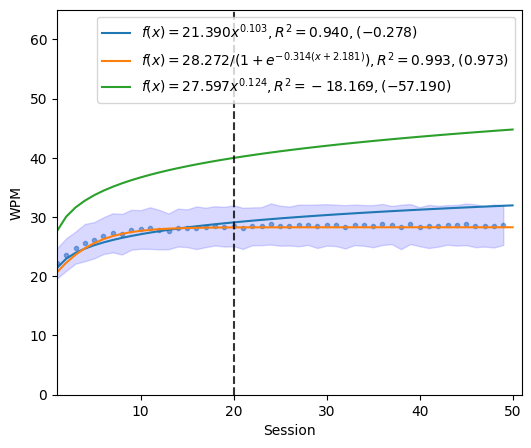

In [13]:
plotdata(m1,s1,c1)